In [7]:
import bs4 as bs
import seaborn as sns
import requests
import pandas_datareader as pdr
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from finta import TA
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score

from module import *

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()
stock = 'WDFC'
data = pdr.DataReader(stock, 'yahoo', start, end)

# Calculate Moving Averages

In [9]:
df = pd.DataFrame(index = data.index)
df.head()

""
Date
2000-01-03
2000-01-04
2000-01-05
2000-01-06
2000-01-07


In [10]:
short_window = 50
long_window = 200
df['short_avg'] = data['Close'].ewm(span = 50, adjust = False).mean()
df['long_avg'] = data['Close'].ewm(span = 200, adjust = False).mean()
df['difference'] = df.short_avg - df.long_avg
df['cross'] = np.sign(df.difference.shift(1))!=np.sign(df.difference)

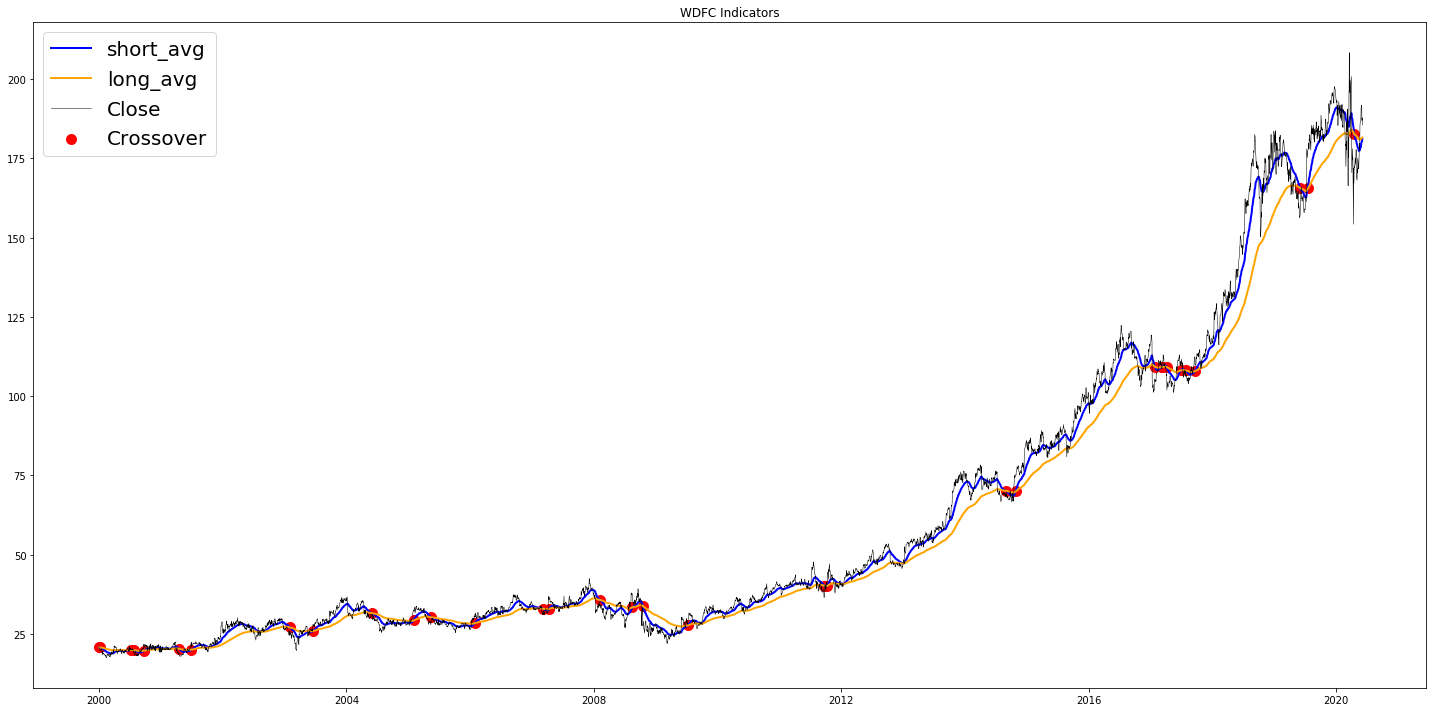

In [11]:
plt.figure(figsize = (20,10))
plt.scatter(df[df.cross == True].index, df[df.cross==True].short_avg, color = 'red', s = 100, label = 'Crossover')
plt.plot(df.short_avg, 'blue', lw = 2, label = 'short_avg')
plt.plot(df.long_avg, 'orange', lw = 2, label = 'long_avg')
plt.plot(data.Close, 'black', label = 'Close', lw = 0.5)

plt.title('WDFC Indicators')
plt.legend(loc = 'upper left', fontsize = 20)
plt.tight_layout()

# ML

In [12]:
SP = pdr.DataReader('SPY', 'yahoo', start, end)
SP['sp_pct_change'] = SP['Adj Close'].pct_change(periods = 1).astype(float)
data = data.merge(SP['sp_pct_change'], left_index = True, right_index = True)
data['pct_change'] = data['Adj Close'].pct_change(periods = 1).astype(float)
data['relative_change'] = data['pct_change'] - data['sp_pct_change']
data.reset_index(inplace = True)
data.columns = [x.lower() for x in data.columns]
data.to_csv('data.csv')

In [7]:
data.head()

,date,high,low,open,close,volume,adj close,sp_pct_change,pct_change,relative_change
0,2000-01-03,22.1250,20.3750,22.12500,20.7500,65100.0,11.669479,NaN,NaN,NaN
1,2000-01-04,21.0000,20.3750,21.00000,20.6250,37000.0,11.599181,-0.039106,-0.006024,0.033082
2,2000-01-05,21.0000,20.0625,20.37500,20.0625,51300.0,11.460655,0.001789,-0.011943,-0.013732
3,2000-01-06,19.8125,19.5000,19.75000,19.7500,56800.0,11.282140,-0.016071,-0.015576,0.000495
4,2000-01-07,20.0000,19.6875,19.78125,20.0000,63100.0,11.424955,0.058076,0.012659,-0.045418


# Add Indicators

In [8]:
indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
              'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MACD', 'PPO', 'VW_MACD', 'EV_MACD',
              'MOM', 'ROC', 'RSI', 'IFT_RSI']

broken_indicators = []

In [9]:
for indicator in indicators:
    if indicator not in broken_indicators:
        df = None
        df = eval('TA.' + indicator + '(data)')
        
        if not isinstance(df, pd.DataFrame):
            df = df.to_frame()
            
        df = df.add_prefix(indicator + '_')
        data = data.merge(df, left_index = True, right_index = True)

data.columns = data.columns.str.replace(' ', '_')

In [10]:
data.head()

,date,high,low,open,close,volume,adj_close,sp_pct_change,pct_change,relative_change,...,PPO_SIGNAL,PPO_HISTO,VW_MACD_MACD,VW_MACD_SIGNAL,EV_MACD_MACD,EV_MACD_SIGNAL,MOM_MOM,ROC_ROC,RSI_RSI,IFT_RSI_IFT_RSI
0,2000-01-03,22.1250,20.3750,22.12500,20.7500,65100.0,11.669479,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN
1,2000-01-04,21.0000,20.3750,21.00000,20.6250,37000.0,11.599181,-0.039106,-0.006024,0.033082,...,-0.007532,-0.006026,-0.002681,-0.001490,0.0,0.0,NaN,NaN,0.000000,NaN
2,2000-01-05,21.0000,20.0625,20.37500,20.0625,51300.0,11.460655,0.001789,-0.011943,-0.013732,...,-0.046541,-0.056172,-0.023460,-0.010494,0.0,0.0,NaN,NaN,0.000000,NaN
3,2000-01-06,19.8125,19.5000,19.75000,19.7500,56800.0,11.282140,-0.016071,-0.015576,0.000495,...,-0.097761,-0.099981,-0.043725,-0.021751,0.0,0.0,NaN,NaN,0.000000,NaN
4,2000-01-07,20.0000,19.6875,19.78125,20.0000,63100.0,11.424955,0.058076,0.012659,-0.045418,...,-0.127032,-0.069129,-0.041139,-0.027518,0.0,0.0,NaN,NaN,24.397296,NaN


# Add short term stock results in relation to current positon

In [11]:
data['short_result'] = None
for index, row in data.iterrows():
    percent_change = data.loc[index + 1:index + 30]['relative_change'].sum()*100
    if math.isnan(percent_change):
        percent_change = 0
    else:
        percent_change = int(round(percent_change))
    data.at[index, 'short_result'] = percent_change
del data['relative_change']

In [12]:
data = data[40:]

# Prepping Data

In [13]:
bins = [-300, -11, -5, 5, 11, 300]
groups = ['strong sell', 'sell', 'hold', 'buy', 'strong buy']
data['short_result'] = pd.cut(data['short_result'], bins = bins, labels = groups)

In [14]:
data.short_result.value_counts()

hold           2644
buy             947
sell            843
strong buy      445
strong sell     218
Name: short_result, dtype: int64

In [15]:
label_encoder = LabelEncoder()
data.short_result = label_encoder.fit_transform(data.short_result)

In [16]:
data.short_result.value_counts()

1    2644
0     947
2     843
3     445
4     218
Name: short_result, dtype: int64

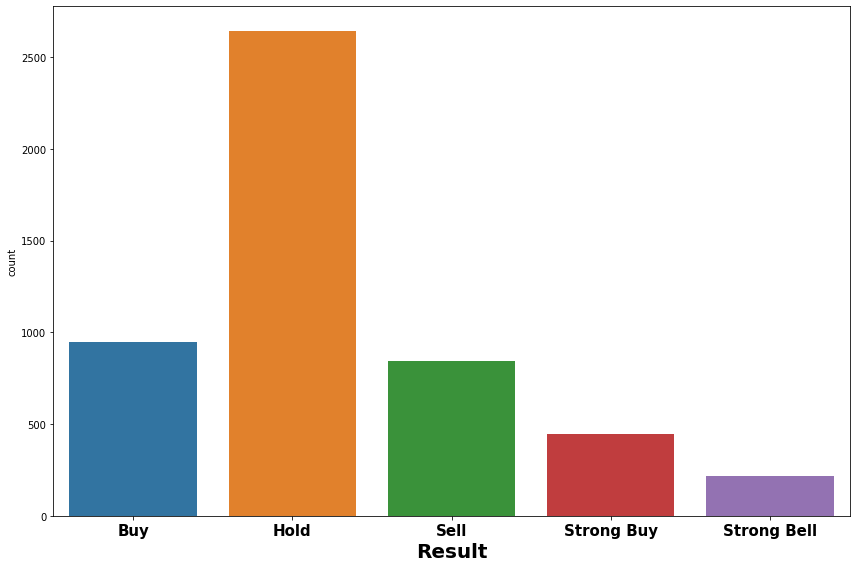

In [17]:
plt.figure(figsize = (12,8))
a = sns.countplot(data.short_result)
a.set_xticklabels(['Buy', 'Hold', 'Sell', 'Strong Buy', 'Strong Bell'], fontsize = 15, fontweight = 'bold')
a.set_xlabel('Result', fontsize = 20, fontweight = 'bold')
plt.tight_layout()

# Train-Test Split

In [18]:
y = data.short_result
X = data.drop(['date','short_result'], axis = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

# Logistic Regression

In [20]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

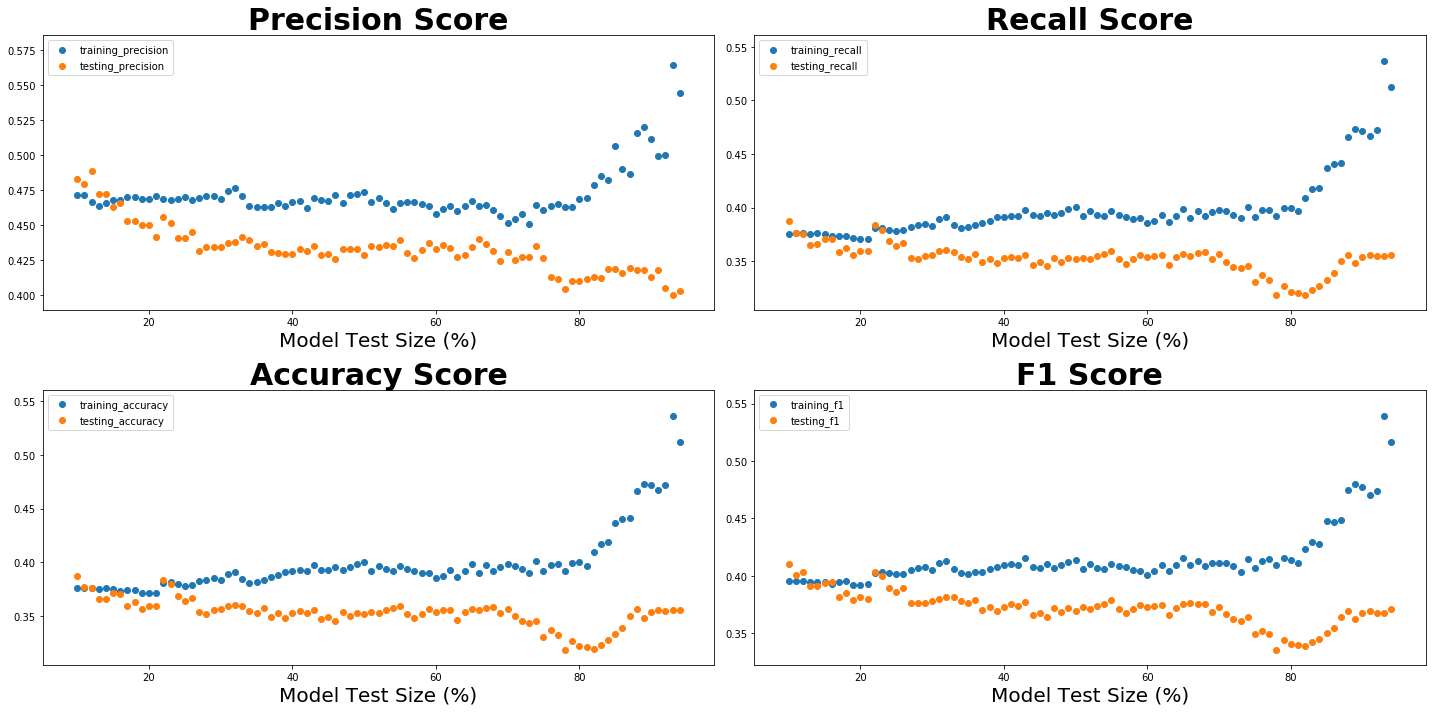

In [38]:
print_metric_comparisons(X_train, y_train)

In [39]:
# Need to adjust the plotting to include CV grid search, not the adjustment of the test size